In [1]:
# !pip install git+https://github.com/Navu45/image-merging.git

In [2]:
import torch
from diffusers import DDIMScheduler, DDIMInverseScheduler
from diffusers.utils import load_image, make_image_grid

from models.pix2pix_image import StableDiffusionPix2PixImagePipeline


In [3]:
pipeline = StableDiffusionPix2PixImagePipeline.from_pretrained(
    'lambdalabs/sd-image-variations-diffusers', revision="v2.0",
    torch_dtype=torch.float16,
    safety_checker=None,
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()
pipeline.enable_xformers_memory_efficient_attention()

vae\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'models.pix2pix_image.StableDiffusionPix2PixImagePipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


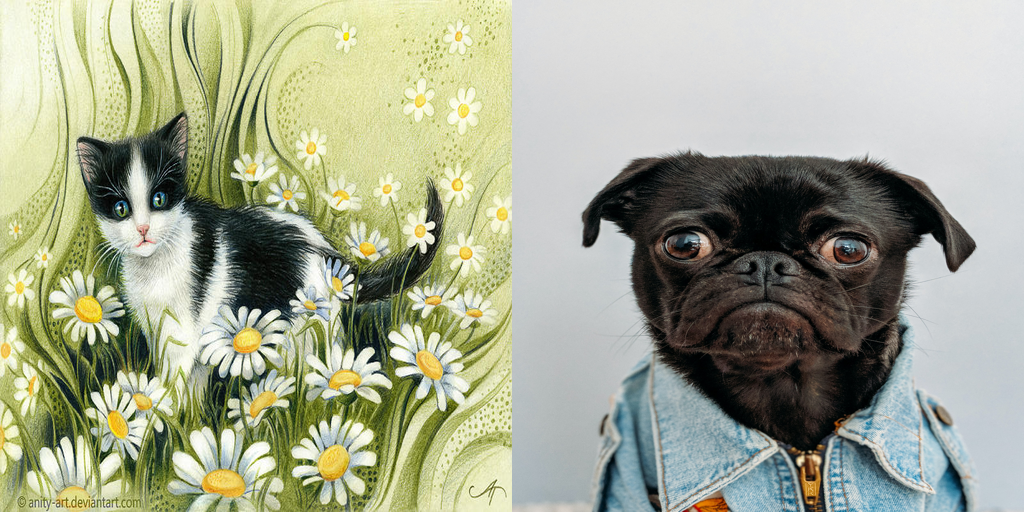

In [4]:
cat_painting = load_image("https://github.com/pix2pixzero/pix2pix-zero/raw/main/assets/test_images/cats/cat_6.png").convert("RGB").resize((512, 512))
dog_image = load_image('https://images.unsplash.com/photo-1518020382113-a7e8fc38eac9?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=2517&q=80').convert("RGB").resize((512, 512))
make_image_grid([cat_painting, dog_image], 1, 2)

In [5]:
cat_painting_embeds = pipeline.encode_image(cat_painting)
dog_image_embeds = pipeline.encode_image(dog_image)

In [6]:
generator = torch.manual_seed(0)
inv_latents, _ = pipeline.invert(source_image=cat_painting, prompt_embeds=cat_painting_embeds,
                              generator=generator, guidance_scale=3.0, return_dict=False)

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
image = pipeline(
    source_embeds=cat_painting_embeds,
    target_embeds=dog_image_embeds,
    num_inference_steps=50,
    cross_attention_guidance_amount=0.15,
    # guidance_scale=3.0,
    generator=generator,
    latents=inv_latents,
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 6.00 GiB total capacity; 5.09 GiB already allocated; 0 bytes free; 5.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF